# Introduction
The rapid advancement of Artificial Intelligence (AI) technologies, particularly in natural language processing, has led to the creation of sophisticated models like Chat Generative Pre-trained Transformer (ChatGPT). These models generate text that closely resembles human-written content and are used extensively for various applications. While these advancements offer numerous opportunities for enhancing productivity and efficiency, they also pose significant challenges in identifying the true origin of the text.

# Research Question
The objective of this project is to analyze the performance of a computational model capable of distinguishing between human-written and AI-generated text. The model will examine key linguistic and stylistic features to identify the unique aspects of human writing. Such a model seeks to enhance transparency and trust in communications by ensuring the authenticity of content. This project aims to address the research question: Can a computational model detect differences between human-written and AI-generated content?

**Dataset Source:** [https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data)

# Results
The results indicate that the Logistic Regression model significantly outperforms the Decision Tree model in classifying text as either human or AI-generated. Logistic Regression achieved an accuracy of 97.22% on raw text and 96.70% on processed text, with F1 scores of 97.20% and 96.66%, respectively. In contrast, the Decision Tree model had an accuracy of 86.38% on raw text and 82.85% on processed text, with F1 scores of 85.86% and 82.37%. Intrestingly, these results suggest that raw text features play an important informative role accross models, and text preprocessing does not necessarily enhance model performance. This indicates that certain preprocessing steps might remove valuable information essential for classification.





![Human vs AI](Human-VS-Ai-Background-Brain-and-heart-hd-background.jpg)

### Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import nltk
import string
import re
import warnings
warnings.simplefilter(action='ignore')
from wordcloud import WordCloud, STOPWORDS
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /Users/spack_h/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/spack_h/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Upload and Setup

In [2]:
#loading data
data = pd.read_csv("AI_Human.csv")
data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [3]:
# Checking datatypes, format, size, and converting to necessary format int
data.info()
data["generated"] = data["generated"].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


#### Data Reduction & Visualization  


In [4]:
# Reducing the size of the dataset to increase speed computation

# Filtering rows by category
human_generated = data[data['generated'] == 0]
ai_generated = data[data['generated'] == 1]

# Sampling 10,000 rows from each category 
human_generated = human_generated.sample(n=10000, random_state=1)
ai_generated = ai_generated.sample(n=10000, random_state=1)

# Putting the rows back together 
reduced_df = pd.concat([human_generated, ai_generated])

# Shuffling the data ~ resetting the index
reduced_df = reduced_df.sample(frac=1, random_state=1).reset_index(drop=True)

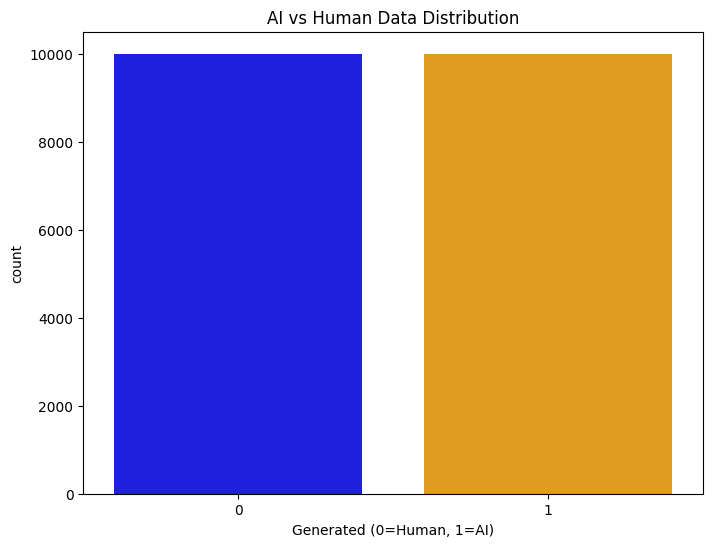

In [5]:
# Visualizing data types distribution

plt.figure(figsize=(8,6))
ax = sns.countplot(x="generated", data=reduced_df, palette=["blue", "orange"])
ax.set_title("AI vs Human Data Distribution")
ax.set_xlabel("Generated (0=Human, 1=AI)")
plt.show()

In [6]:
# Showing an exmaple of Human generated text

print("Human generated text: ")
reduced_df[reduced_df["generated"] == 0].sample(1)["text"].iloc[0]


Human generated text: 


'Po start with, THA challenge of Exploring Vagus is that it\'s more that just OMA challenge it\'s several. far Ara terrible weather conditions, City times THA pressure WA have OJ our plants, clouds of highly corrosive sulfuric acid, and a to of other challenges.\n\nFirst of all, THA heat conditions OJ THA plant Vagus Ara close to Light times THA heat that WA\'VA Agar fact OJ our plant. PhA average Tamara OJ Vagus is around Light hundred diagrams FarAJhAit Vary day. Phis heat could malt SOMA of THA metals that WA have OJ our plant, Earth. OJ days that Ara around City diagrams OJ our plant it is very hot imaging being IJ that heat but times Light. Paola would did from THA heat of that plant and this is OMA reason why it makes it such a great challenge to Explore Vagus.\n\nSecond, according to paragraph 3 of THA article it States "THA atmospheric pressure is 90 times Gravatar that what WA AxpAriAJcA OJ our own plant." Living OJ this plant seams to BA company ISARA! PhA pressure OJ this pl

In [7]:
# Showing an exmaple of AI generated text

print("AI generated text: ")
reduced_df[reduced_df["generated"] == 1].sample(1)["text"].iloc[0]

AI generated text: 


'When faced with an important decision, it is wise to seek advice from more than one person. Getting different perspectives allows you to haze a more well rounded view of the situation and potential options. Each person you talk to May haze valuable insights that the others did not consider. \n\nFor example, if you were deciding between two job offers, talking to just one friend might highlight the benefits of one option over the other based on that person\'s biases or experiences. However, getting opinions from other trusted friends or family members could draw your attention to important factors like work life balance, company culture, career growth opportunities, or location that the first advisor did not emphasize. Considering a variety of viewpoints helps ensure you do not overlook any critical details as you weigh the pros and cons.\n\nIn addition, other people may challenge your initial assumptions in a way that one advisor could not. While your friend may agree with your precon

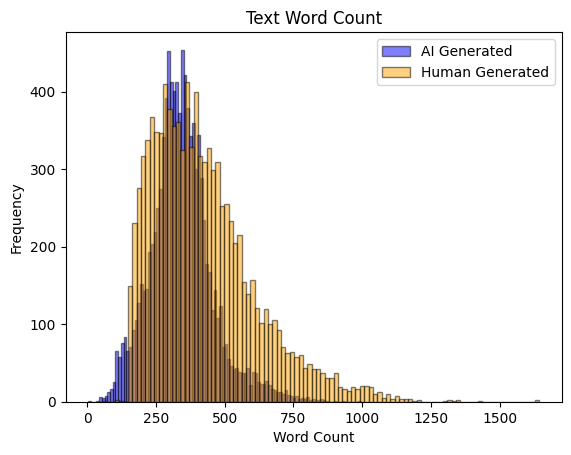

In [8]:
# Visualizing Word Count 

# Filter data based on 'generated' category
ai_generated_text = reduced_df[reduced_df['generated'] == 1]
human_generated_text = reduced_df[reduced_df['generated'] == 0]

# Calculate word counts without adding columns to the DataFrame
ai_word_counts = ai_generated_text['text'].apply(lambda x: len(x.split()))
human_word_counts = human_generated_text['text'].apply(lambda x: len(x.split()))

# Create the histogram using matplotlib
fig, ax = plt.subplots()
ax.hist(ai_word_counts, bins=100, color='blue', alpha=0.5, edgecolor='black', label='AI Generated')
ax.hist(human_word_counts, bins=100, color='orange', alpha=0.5, edgecolor='black', label='Human Generated')

ax.set_title('Text Word Count')
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.legend()

plt.show()

#### Text Preprocessing & Splitting

In [9]:
# Defining function for tokenization, removing stop words, punctuation, setting lower case, and lemmatizing
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case=False)
    swords = set(stopwords.words('english'))
    punc = set(string.punctuation)
    lemmatizer = WordNetLemmatizer()

    processed_text = []
    for entry in text:
        entry = re.sub(r'\d+', '', entry)  # Removing numbers
        tokens = tokenizer.tokenize(entry)  # Tokenizing text
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in swords and word not in punc]
        processed_entry = ' '.join(tokens)  # Join tokens back into a single string
        processed_text.append(processed_entry)
    return processed_text

In [10]:
# Creating two copies of the dataset 
raw_data = reduced_df.copy()
processed_data = reduced_df.copy()

In [11]:
# Applying preprocessing to one half of the dataset
processed_data["text"] = preprocess_text(processed_data["text"])
processed_data.head()

,text,generated
0,college graduate often earn higher salary coll...,1
1,issue whether tell family member cancer diagno...,1
2,hey talk think suspicious face think probably ...,0
3,dear principal writing express concern propose...,1
4,people seek guidance help like u still trouble...,0


### Vectorization

In [12]:
# Splitting data into train and test sets for both raw and preprocessed text
X1 = raw_data["text"]
y1 = raw_data['generated']
X2 = processed_data["text"]
y2 = processed_data['generated']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [13]:
# Vectorizing using TF-IDF vectorizer
vectorizer1 = TfidfVectorizer()
vectorizer2 = TfidfVectorizer()

# Raw text
X1_train_tfidf = vectorizer1.fit_transform(X1_train)
X1_test_tfidf = vectorizer1.transform(X1_test)

# Preprocessed text
X2_train_tfidf = vectorizer2.fit_transform(X2_train)
X2_test_tfidf = vectorizer2.transform(X2_test)

### Model Training and Evaluation

In [14]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names, title):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def prediction(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pr = model.predict(X_test)
    acc_score = accuracy_score(y_test, pr)
    f1 = f1_score(y_test, pr, average="binary", pos_label=1)
    cm = confusion_matrix(y_test, pr)
    return acc_score, f1, cm, pr

# Function to calculate True Positives, False Positives, False Negtives, and True Negatieves
def calculate_confusion_metrics(cm):
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tn = cm[0, 0]
    return tp, fp, fn, tn

In [15]:
#Classifiers models and Metrics

# Initialize classifiers
lg = LogisticRegression(penalty='l1', solver='liblinear')
dtc = DecisionTreeClassifier(max_depth=5)

# Initialize dictionaries to store metrics
acc_score_raw = {}
f1_scores_raw = {}
acc_score_processed = {}
f1_scores_processed = {}
conf_matrices_raw = {}
conf_matrices_processed = {}

In [16]:
# Running Logistic Regression Model:

# Raw Data
acc_score_raw['Logistic Regression'], f1_scores_raw['Logistic Regression'], conf_matrices_raw['Logistic Regression'], _ = prediction(lg, X1_train_tfidf, X1_test_tfidf, y1_train, y1_test)

# Processed Data
acc_score_processed['Logistic Regression'], f1_scores_processed['Logistic Regression'], conf_matrices_processed['Logistic Regression'], _ = prediction(lg, X2_train_tfidf, X2_test_tfidf, y2_train, y2_test)


In [17]:
# Running Decision Tree Model:

# Run Decision Tree on Raw Data
acc_score_raw['Decision Tree'], f1_scores_raw['Decision Tree'], conf_matrices_raw['Decision Tree'], _ = prediction(dtc, X1_train_tfidf, X1_test_tfidf, y1_train, y1_test)

# Run Decision Tree on Processed Data
acc_score_processed['Decision Tree'], f1_scores_processed['Decision Tree'], conf_matrices_processed['Decision Tree'], _ = prediction(dtc, X2_train_tfidf, X2_test_tfidf, y2_train, y2_test)


In [18]:
# Computing confusion matrix metrics for each model and data type
tp_fp_fn_tn = {
    'Logistic Regression (Raw)': calculate_confusion_metrics(conf_matrices_raw['Logistic Regression']),
    'Logistic Regression (Processed)': calculate_confusion_metrics(conf_matrices_processed['Logistic Regression']),
    'Decision Tree (Raw)': calculate_confusion_metrics(conf_matrices_raw['Decision Tree']),
    'Decision Tree (Processed)': calculate_confusion_metrics(conf_matrices_processed['Decision Tree'])
}

In [19]:
# Computing confusion matrix metrics for each model and data type
tp_fp_fn_tn = {
    'Logistic Regression (Raw)': calculate_confusion_metrics(conf_matrices_raw['Logistic Regression']),
    'Logistic Regression (Processed)': calculate_confusion_metrics(conf_matrices_processed['Logistic Regression']),
    'Decision Tree (Raw)': calculate_confusion_metrics(conf_matrices_raw['Decision Tree']),
    'Decision Tree (Processed)': calculate_confusion_metrics(conf_matrices_processed['Decision Tree'])
}

### Logistic Regression Results

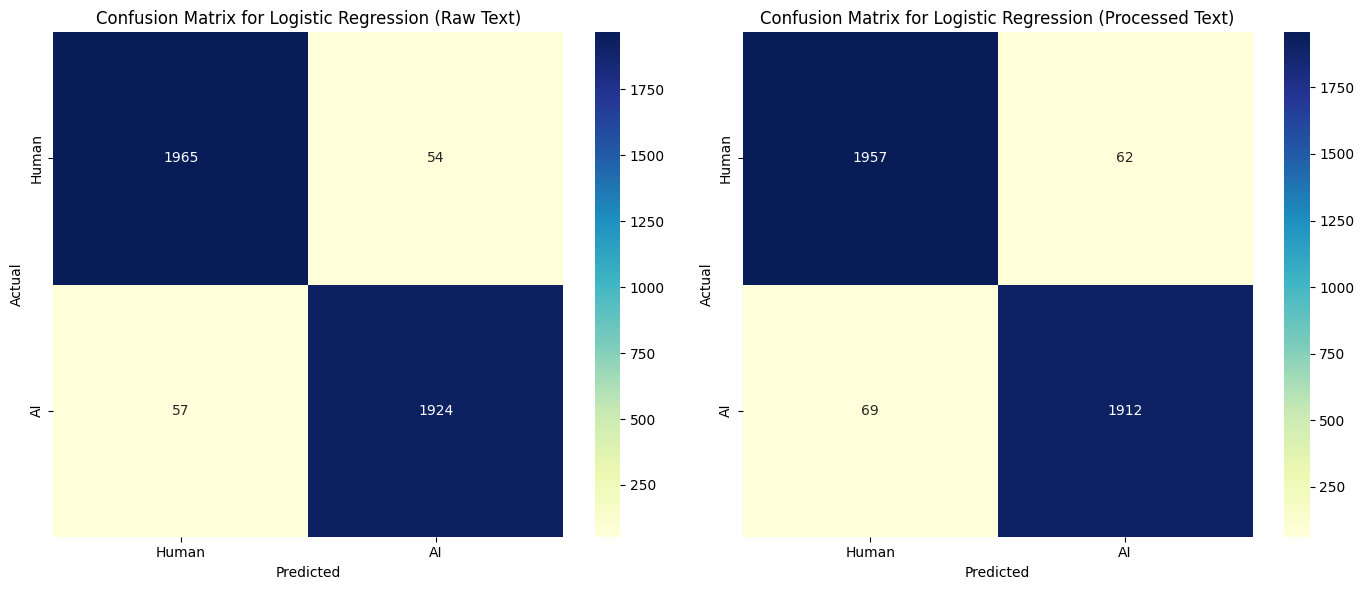

In [20]:
# Visulining confusion matrices by side for raw and processed data

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axes[0].set_title("Confusion Matrix for Logistic Regression (Raw Text)")
sns.heatmap(pd.DataFrame(conf_matrices_raw['Logistic Regression'], index=["Human", "AI"], columns=["Human", "AI"]), annot=True, cmap="YlGnBu", fmt='g', ax=axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title("Confusion Matrix for Logistic Regression (Processed Text)")
sns.heatmap(pd.DataFrame(conf_matrices_processed['Logistic Regression'], index=["Human", "AI"], columns=["Human", "AI"]), annot=True, cmap="YlGnBu", fmt='g', ax=axes[1])
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

### Decision Tree Results

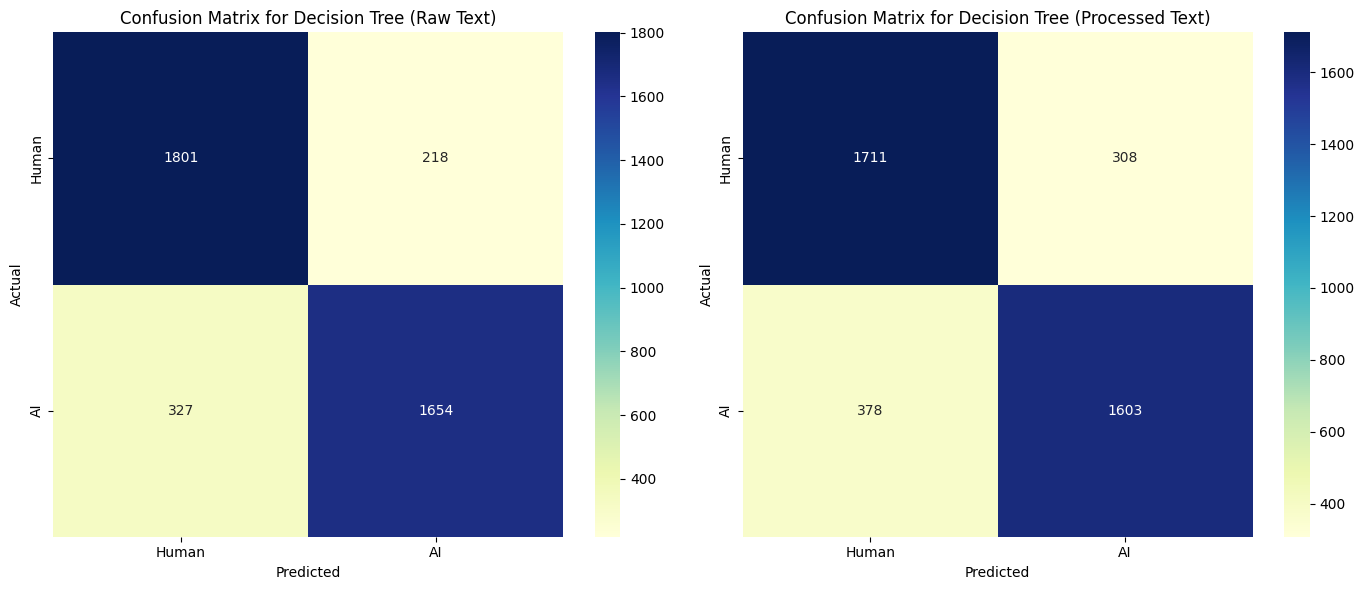

In [21]:
# Visulining confusion matrices by side for raw and processed data

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axes[0].set_title("Confusion Matrix for Decision Tree (Raw Text)")
sns.heatmap(pd.DataFrame(conf_matrices_raw['Decision Tree'], index=["Human", "AI"], columns=["Human", "AI"]), annot=True, cmap="YlGnBu", fmt='g', ax=axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title("Confusion Matrix for Decision Tree (Processed Text)")
sns.heatmap(pd.DataFrame(conf_matrices_processed['Decision Tree'], index=["Human", "AI"], columns=["Human", "AI"]), annot=True, cmap="YlGnBu", fmt='g', ax=axes[1])
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

### Model Performance Interpretation

In [22]:
# Generating a DataFrame to hold the results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Decision Tree'],
    'Data Type': ['Raw Text', 'Processed Text', 'Raw Text', 'Processed Text'],
    'Accuracy': [acc_score_raw['Logistic Regression'], acc_score_processed['Logistic Regression'], acc_score_raw['Decision Tree'], acc_score_processed['Decision Tree']],
    'F1 Score': [f1_scores_raw['Logistic Regression'], f1_scores_processed['Logistic Regression'], f1_scores_raw['Decision Tree'], f1_scores_processed['Decision Tree']],
    'True Positives': [tp_fp_fn_tn['Logistic Regression (Raw)'][0], tp_fp_fn_tn['Logistic Regression (Processed)'][0], tp_fp_fn_tn['Decision Tree (Raw)'][0], tp_fp_fn_tn['Decision Tree (Processed)'][0]],
    'False Positives': [tp_fp_fn_tn['Logistic Regression (Raw)'][1], tp_fp_fn_tn['Logistic Regression (Processed)'][1], tp_fp_fn_tn['Decision Tree (Raw)'][1], tp_fp_fn_tn['Decision Tree (Processed)'][1]],
    'False Negatives': [tp_fp_fn_tn['Logistic Regression (Raw)'][2], tp_fp_fn_tn['Logistic Regression (Processed)'][2], tp_fp_fn_tn['Decision Tree (Raw)'][2], tp_fp_fn_tn['Decision Tree (Processed)'][2]],
    'True Negatives': [tp_fp_fn_tn['Logistic Regression (Raw)'][3], tp_fp_fn_tn['Logistic Regression (Processed)'][3], tp_fp_fn_tn['Decision Tree (Raw)'][3], tp_fp_fn_tn['Decision Tree (Processed)'][3]]
})

# Converting accuracy and F1 score to percentages and rounding them to 2 decimal points
results['Accuracy'] = round((results['Accuracy'] * 100), 2)
results['F1 Score'] = round((results['F1 Score'] * 100), 2)

results

,Model,Data Type,Accuracy,F1 Score,True Positives,False Positives,False Negatives,True Negatives
0,Logistic Regression,Raw Text,97.22,97.20,1924,54,57,1965
1,Logistic Regression,Processed Text,96.72,96.69,1912,62,69,1957
2,Decision Tree,Raw Text,86.38,85.86,1654,218,327,1801
3,Decision Tree,Processed Text,82.85,82.37,1603,308,378,1711


### Conclusion

**For this dataset, the Logistic Regression model is more effective than the Decision Tree model, achieving higher accuracy and F1 scores on both raw and processed text. Additionally, raw text features yield better performance for both models compared to processed text, indicating that preprocessing might not always lead to improved performance and can sometimes result in a loss of valuable information.**

#### Logistic Regression:
- **Raw Text**: Higher accuracy and F1 score.
- **Processed Text**: Slightly lower but still superior performance compared to Decision Tree.

#### Decision Tree:
- **Raw Text**: Lower accuracy and F1 score compared to Logistic Regression.
- **Processed Text**: Even lower performance, indicating potential loss of information due to preprocessing.
